In [166]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from convnwb.paths import Paths
from convnwb.io import get_files, load_jsons_to_df, load_matfile
from scipy.stats import binom_test, chi2_contingency

from spiketools.plts.data import plot_hist
from spiketools.plts.utils import make_axes
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [167]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [168]:
import sys
sys.path.append('../scripts')
from settings import RUN, PATHS, UNITS,METHODS, SURROGATES

In [169]:
results_folder = PATHS['RESULTS'] / 'units_matlab'
reports_folder = PATHS['REPORTS'] / 'units_matlab'


In [170]:
# Get the list of files
res_files = get_files(results_folder, select='mat')

In [171]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [172]:
# Check the columns
all_results.columns

Index(['unit_ind', 'session_id', 'place_bins', 'place_bins_trial', 'place_sem',
       's_bins', 'place_info', 'place_anova', 'place_anova_surr_p_val',
       'place_anova_surr_z_score', 'place_info_surr_p_val',
       'place_info_surr_z_score'],
      dtype='object')

In [173]:
# Check similarity of low firing rate & low presence ratio
#low_frs = (all_results['firing_rate'] < 0.1).values
#print('# neurons fr < 0.1: \t', sum(all_results.firing_rate < 0.1))
# Add a marker for firing rate threshold in the TH experiment
#all_results['keep_sh'] = (all_results['firing_rate'] > 0.1).values


## Dropped Neurons 

In [174]:
# Extract dropped neurons
# dropped = all_results[~all_results['keep_sh']]

In [175]:
# Check number of dropped neurons
# n_dropped = len(dropped)
# print('# of dropped units: \t{}'.format(n_dropped))

In [176]:
# Sub-select main results file to keep neurons
#all_results = all_results[all_results['keep_sh']]

## Check Results 

In [177]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))

Total number of cells: 354


In [178]:
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'    # 'two-sided', 'greater', 'less'

In [179]:
# Collect numbers of significant cells
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values
#     print(all_results[f'{analysis}_surr_p_val'])
    #results[analysis] = sum(all_results['is_' + analysis])

In [180]:
for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])

In [181]:
# Compute significance of the counts of detected neurons
stats = {}
for analysis in analyses:
    stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_2341/2198180662.py:4: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [182]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, stats[analysis]))

total cells: 354

# place_anova cells:     		 69  (19.49%) 		 0.0000
# place_info cells:     		 78  (22.03%) 		 0.0000


## Group Level Analysis 

In [183]:
df_cleaned = all_results.dropna()
place_info = df_cleaned['place_info']
place_anova = df_cleaned['place_anova']
place_info_surr_p_val =  df_cleaned['place_info_surr_p_val']
place_anova_surr_p_val =  df_cleaned['place_anova_surr_p_val']

In [184]:
SI = all_results['place_info']
F = all_results['place_anova']

si_pval =  all_results['place_info_surr_p_val']
anova_pval =  all_results['place_anova_surr_p_val']

In [185]:
len(F[anova_pval < 0.05])

69

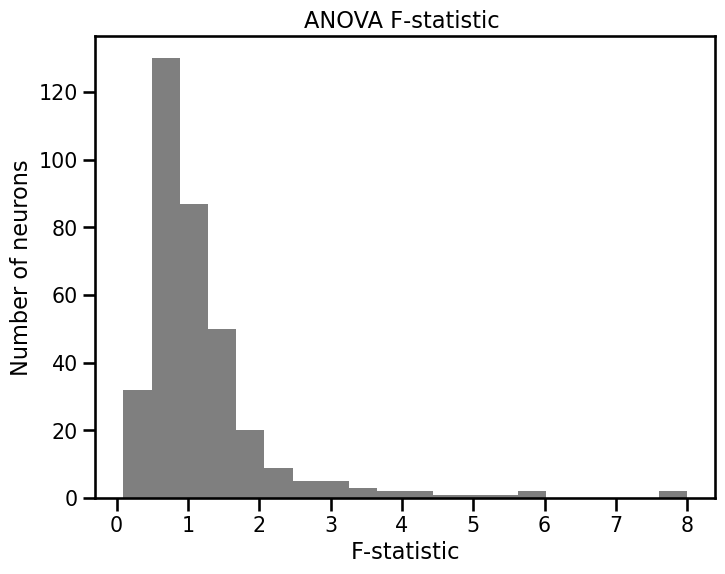

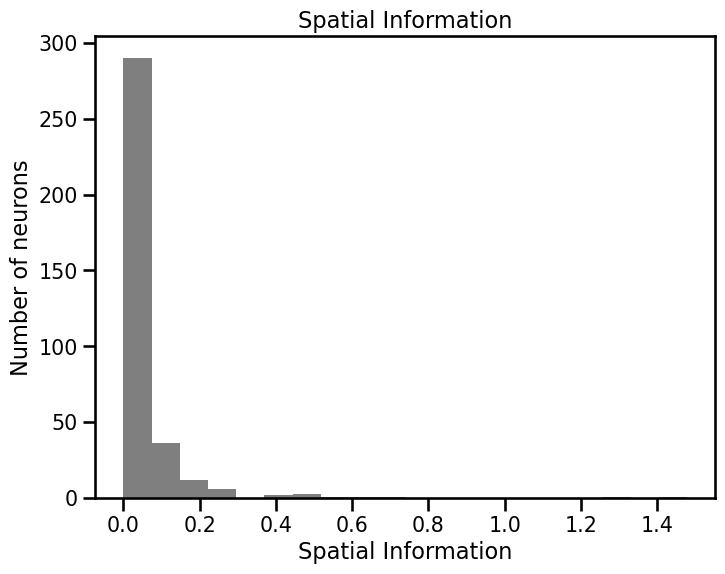

In [186]:
plot_hist(all_results['place_anova'].values,  bins=20, color='black', alpha=0.5, xlabel='F-statistic', ylabel='Number of neurons', title='ANOVA F-statistic ', figsize=(8, 6))

plot_hist(all_results['place_info'].values,  bins=20, color='black', alpha=0.5, xlabel='Spatial Information', ylabel='Number of neurons', title='Spatial Information', figsize=(8, 6))



In [187]:
def get_significant_percentage(stats_vals,p_vals,increment,threshold = 0.05):

    ## Calculate the number of steps
    # Remove NaN values
    valid_mask = ~np.isnan(stats_vals)
    stats_vals = stats_vals[valid_mask]
    p_vals = p_vals[valid_mask]
    
    max_value = int(np.max(stats_vals))+1
    n_step = int(max_value/increment)
    categories = []
    significant_percentages = []
    for i in range(n_step):
        lower_bound = i*increment
        upper_bound = (i+1)*increment

        # Find indices and compute percentage of significant p values
        indx_in_category = np.where((stats_vals >=lower_bound)& (stats_vals < upper_bound))[0]
        if len(indx_in_category) > 0:
            p_vals_in_category = p_vals[indx_in_category]
            significant_p_vals = p_vals_in_category[p_vals_in_category<threshold]

            n_significant_p_vals = len(significant_p_vals)
            significant_percentage = (n_significant_p_vals / len(p_vals_in_category)) * 100
            category = upper_bound
        else:
            significant_percentage = None
            category = None
        
        significant_percentages.append(significant_percentage)
        categories.append(category)
    return categories,significant_percentages


In [188]:
anova_steps,anova_significant_percentages = get_significant_percentage(all_results['place_anova'].values,all_results['place_anova_surr_p_val'].values,increment = 0.2,threshold = 0.05)

info_steps,info_significant_percentages = get_significant_percentage(all_results['place_info'].values,all_results['place_info_surr_p_val'].values,increment = 0.2,threshold = 0.05)


In [152]:
import numpy as np
import matplotlib.pyplot as plt


from spiketools.plts.utils import check_ax, get_kwargs, savefig
from spiketools.plts.settings import SET_KWARGS, OTHER_KWARGS
from spiketools.plts.style import set_plt_kwargs

@set_plt_kwargs
def plot_percentages(steps,percentages,ax= None,**plt_kwargs):
    ax = check_ax(ax,figsize = plt_kwargs.pop('figsize',None))
    ax.plot(steps,percentages,**plt_kwargs)

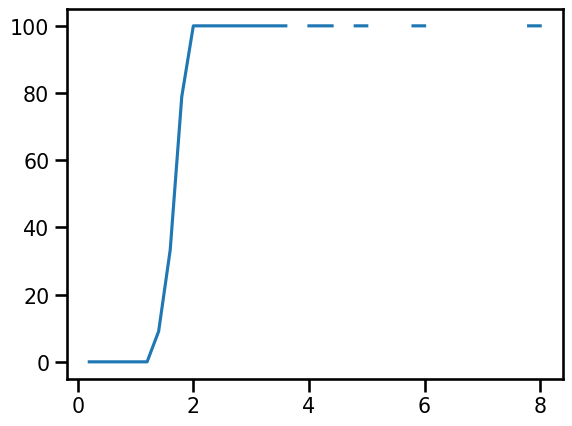

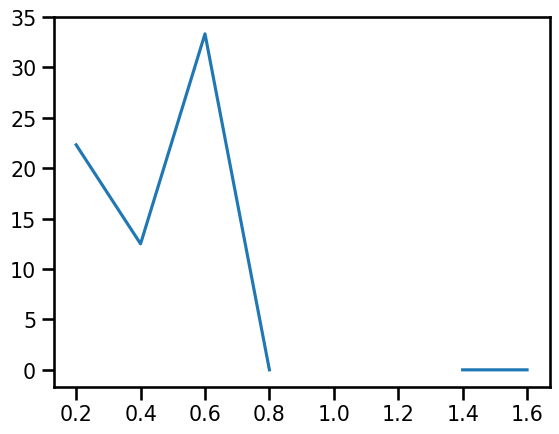

In [153]:
plot_percentages(anova_steps,anova_significant_percentages)

plot_percentages(info_steps,info_significant_percentages)


In [154]:
def get_agreement_percentage(stats, p_values1, p_values2, increment=0.2,threshold = 0.05):
    """
    Calculate the percentage of agreement between two sets of p-values.
    """
    # Remove NaN values
    valid_mask = ~np.isnan(stats)
    stats = stats[valid_mask]
    p_values1 = p_values1[valid_mask]
    p_values2 = p_values2[valid_mask]

    if len(stats) == 0:
        return [], [], [], []

    max_value = int(np.max(stats)) + 1
    num_steps = int(max_value / increment)
    categories = []
    agreement_percentages = []
    significant_percentages = []
    not_significant_percentages  = []

    for i in range(num_steps):  # Loop over increments
        lower_bound = i * increment
        upper_bound = (i + 1) * increment
        categories.append(upper_bound)
        indices_in_category = np.where((stats >= lower_bound) & (stats < upper_bound))[0]

        if len(indices_in_category) > 0:
            p_values1_in_category = p_values1[indices_in_category]
            p_values2_in_category = p_values2[indices_in_category]

            significant_indices = (p_values1_in_category < threshold) & (p_values2_in_category < threshold)
            not_significant_indices = (p_values1_in_category > threshold) & (p_values2_in_category > threshold)

            n_agree = np.sum(significant_indices)+np.sum(not_significant_indices)  # Count significant values

            # Calculate percentage
            agreement_percentages.append(n_agree / len(indices_in_category) * 100)
            significant_percentages.append(np.sum(significant_indices) / len(indices_in_category) * 100)
            not_significant_percentages.append(np.sum(not_significant_indices) / len(indices_in_category) * 100)
        else:
            agreement_percentages.append(None)
            significant_percentages.append(None)
            not_significant_percentages.append(None)
    return categories, agreement_percentages, significant_percentages, not_significant_percentages

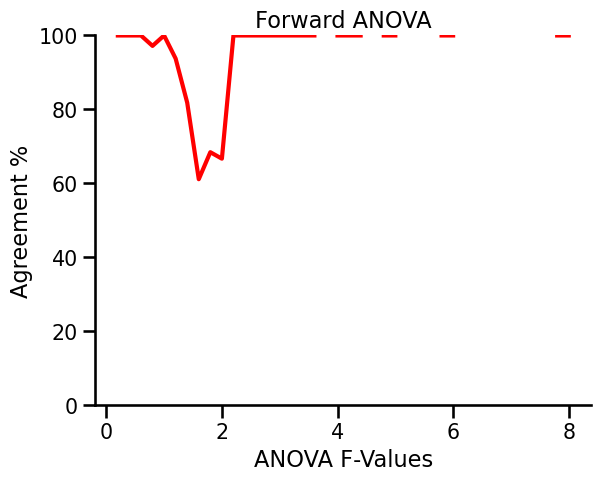

In [155]:
anova_categories, anova_agreement_percentages, anova_agree_significant_percentages, anova_agree_not_significant_percentages = get_agreement_percentage(all_results['place_anova'].values,all_results['place_anova_surr_p_val'].values,all_results['place_info_surr_p_val'].values,increment=.2)
plot_percentages(anova_categories,anova_agreement_percentages,ylim = [0,100],ylabel = 'Agreement %',xlabel = 'ANOVA F-Values',title = 'Forward ANOVA',color = 'red',lw = 3)
drop_spines(['top','right'])



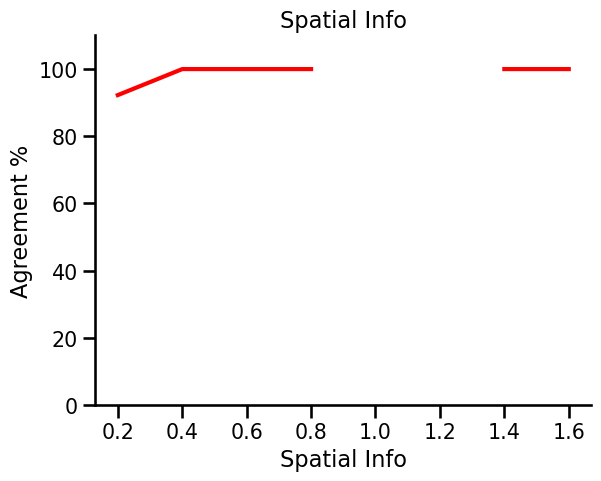

In [156]:
info_categories, info_agreement_percentages, info_agree_significant_percentages, info_agree_not_significant_percentages = get_agreement_percentage(all_results['place_info'].values,all_results['place_info_surr_p_val'].values,all_results['place_anova_surr_p_val'].values,increment=.2)
plot_percentages(info_categories,info_agreement_percentages,ylim = [0,110],ylabel = 'Agreement %',xlabel = 'Spatial Info',title = 'Spatial Info',color = 'red',lw = 3)
drop_spines(['top','right'])

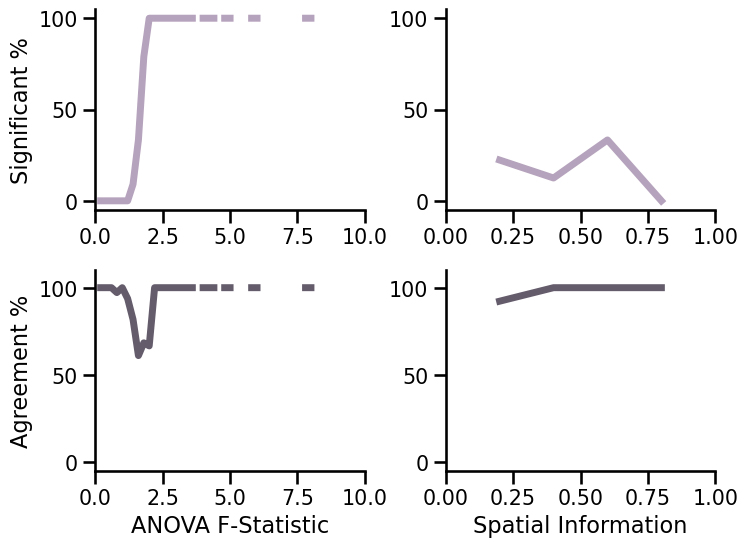

In [157]:
from spiketools.plts.utils import save_figure
grid = make_grid(2, 2, wspace=.3, hspace=.3, figsize=(8, 6),
                 )
plt.rcParams.update({'font.size': 50})

ax = get_grid_subplot(grid, 0, 0)
plot_percentages(anova_steps,anova_significant_percentages,xlim = [0,10],ylim = [-5,105],ylabel = 'Significant %',color = '#B5A2BC',lw = 5,ax = ax)
#add_vlines(1.8,color = 'blue',linestyle = '--',lw = 3)
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 1)
plot_percentages(info_steps,info_significant_percentages,xlim = [0,1],ylim = [-5,105], color = '#B5A2BC',lw = 5,ax = ax)
#add_vlines(0.25,color = 'red',linestyle = '--',lw = 3)
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 0)
#add_vlines(1.8,color = 'blue',linestyle = '--',lw = 3)
plot_percentages(anova_categories,anova_agreement_percentages,xlim = [0,10],ylim = [-5,110],ylabel = 'Agreement %',xlabel = 'ANOVA F-Statistic',color = '#645B6B',lw = 5,ax = ax)
#add_vlines(1.8,color = 'blue',linestyle = '--',lw = 3)
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 1)
plot_percentages(info_categories,info_agreement_percentages,xlim = [0,1],ylim = [-5,110],xlabel = 'Spatial Information',color = '#645B6B',lw = 5,ax = ax)
#add_vlines(0.25,color = 'red',linestyle = '--',lw = 3)
drop_spines(['top','right'])


save_figure('Train_Significant_Agreement_Percentage',file_path='/Users/weijiazhang/Plots/PLDM/Human')

## Significant for Spike Information 

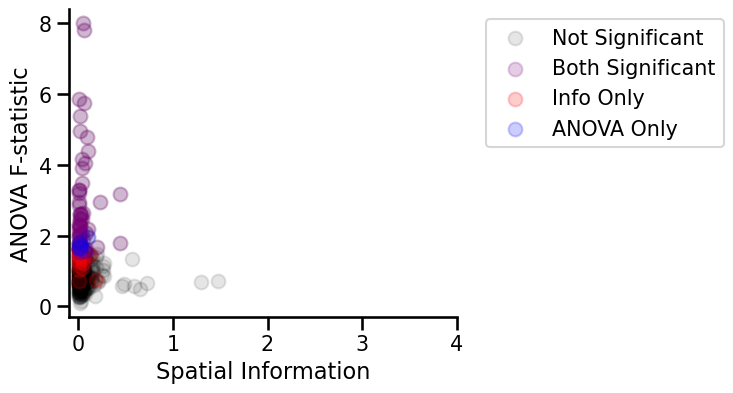

In [163]:
grid = make_grid(1, 1, wspace=.2, hspace=.6, figsize=(5, 4))
threshold = 0.05
ax=get_grid_subplot(grid,0, 0)
mask = (place_anova_surr_p_val < threshold) & (place_info_surr_p_val < threshold)
mask_info = (place_info_surr_p_val < threshold) & (place_anova_surr_p_val >=threshold)
mask_anova = (place_anova_surr_p_val < threshold) & (place_info_surr_p_val >=threshold)

# Plot background points first
ax.scatter(place_info, place_anova,s=100,alpha=.1,color='k', label='Not Significant')

# Plot significant points on top
ax.scatter(place_info[mask], place_anova[mask],s=100,alpha=.2,color='purple', label='Both Significant')
ax.scatter(place_info[mask_info],place_anova[mask_info],s=100,alpha = .2,color = 'red', label='Info Only')
ax.scatter(place_info[mask_anova],place_anova[mask_anova],s=100,alpha =.2,color = 'blue', label='ANOVA Only')

drop_spines(['top','right'])
ax.set_xlabel('Spatial Information')
ax.set_ylabel('ANOVA F-statistic')
ax.set_xlim([-.1,4])
#ax.set_ylim([-10,400])

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('/Users/weijiazhang/Plots/PLDM/Human/distribution_train.png', 
            dpi=300, bbox_inches='tight')
plt.show()


True positives: 59 (16.8%)
False positives: 17 (4.8%)
False negatives: 8 (2.3%)
True negatives: 268 (76.1%)
Phi correlation coefficient: 0.78


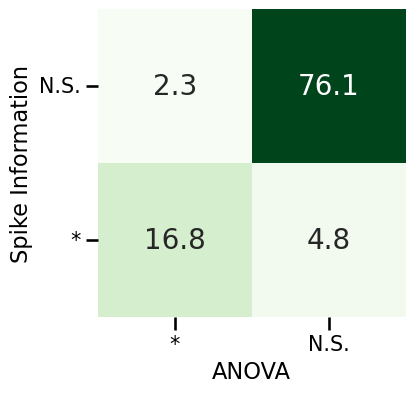

In [165]:
threshold = 0.05
significant_spike_info = (place_info_surr_p_val < threshold)
significant_anova = (place_anova_surr_p_val < threshold)

total_cells = len(significant_spike_info)

# True positive: Significant in both
tp = np.sum(significant_spike_info & significant_anova)
tp_pct = (tp/total_cells)*100
print(f"True positives: {tp} ({tp_pct:.1f}%)")

# False positive: Significant in Spike Info, not in ANOVA
fp = np.sum(significant_spike_info & ~significant_anova) 
fp_pct = (fp/total_cells)*100
print(f"False positives: {fp} ({fp_pct:.1f}%)")

# False negative: Not significant in Spike Info, significant in ANOVA
fn = np.sum(~significant_spike_info & significant_anova)
fn_pct = (fn/total_cells)*100
print(f"False negatives: {fn} ({fn_pct:.1f}%)")

# True negative: Not significant in both
tn = np.sum(~significant_spike_info & ~significant_anova)
tn_pct = (tn/total_cells)*100
print(f"True negatives: {tn} ({tn_pct:.1f}%)")

# Creating a 2x2 matrix with percentages
data = np.array([
    [fn, tn],
    [tp, fp]
])

data_pct = np.array([
    [fn_pct, tn_pct],
    [tp_pct, fp_pct]
])

# Creating a DataFrame for the heatmap with counts and percentages
forward_df = pd.DataFrame(data, index=['N.S.', '*'],
                  columns=['*', 'N.S.'])

# Add subplot to grid and plot heatmap
grid = make_grid(1, 1, wspace=.2, hspace=.6, figsize=(5, 4))
ax = get_grid_subplot(grid,0, 0)
heatmap = sns.heatmap(forward_df, annot=data_pct, fmt='.1f', cmap='Greens', cbar=False, square=True, ax=ax)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=360, ha='center')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=360)
heatmap.set_xlabel('ANOVA')
heatmap.set_ylabel('Spike Information')

def phi_coefficient(a, b, c, d):
    numerator = (a * d) - (b * c)
    denominator = np.sqrt((a + b) * (a + c) * (b + d) * (c + d))
    phi = numerator / denominator
    return phi

phi = phi_coefficient(tp, fp, fn, tn)
print(f'Phi correlation coefficient: {phi:.2f}')

# Save figure before showing
plt.savefig('/Users/weijiazhang/Plots/PLDM/Human/Train_two_by_two_matrix.png', 
            dpi=300, bbox_inches='tight')
plt.show()